# Teacher Statistics

In this notebook we will explore the statistics about teachers revealed by this data. There is certainly little reliability in how the data was collected but it is worth exploring how what nuance may exist in this large corpus of reviews and how we may be able to leverage the data for improved NLP analysis. 

This notebook will be updated over time as they become relevat to the publication being worked on. For now, the scheduled updates include: 
- Upgrade graphs to use `plotly`
- Incorporate more comprehensive time-series plots

In [2]:
import os 
import numpy as np
import pandas as pd
import bear_necessities as bn
import seaborn as sns 
import matplotlib.pyplot as plt

In [3]:
# import the data
data = bn.decompress_pickle(os.getcwd() + '/data/review_stats.pbz2')

In [14]:
data.loc[data['Rating']<35,'Teacher'].unique()

array(['/dixon/465031-t', '/irene-b-jones/244663-t',
       '/cullpepper/202644-t', ..., '/tim-mcgee/324409-t',
       '/lance-picore/324425-t', '/mark-hansen/324440-t'], dtype=object)

### Adding to The Data

First step is to add some variables to the data which will be useful in analyzing the data further. 

*Date variables and academic year:*

In [10]:
# create date variables including academic year 
data['Year'] = data['DateTime'].apply(lambda d: d.split('-')[0]).astype(int)
data['Month'] = data['DateTime'].apply(lambda d: d.split('-')[1]).astype(int)
data['Academic_Year'] = np.where(data['Month']>7,data['Year']+1,data['Year'])
data['Academic_Year'] = data['Academic_Year'].apply(lambda y : str(y-1)+'-'+str(y))

*The number of years a teacher received a review:*

In [149]:
# lets take a look at how some teachers are rated over time 
data['N_Years_Reviewed'] = data.groupby('Teacher')['Academic_Year'].transform('unique')
data['N_Years_Reviewed'] = data['N_Years_Reviewed'].apply(lambda y: len(y))

### Additional Objects
We also create additional objects from the data that will help us review it further.

*The years each teacher taught:*

In [5]:
# create a grouped dataset with the number of unique academic years for each teacher\n",
n_years = data.groupby('Teacher')['Academic_Year'].unique()
n_years = pd.DataFrame(n_years)
bn.compressed_pickle(os.getcwd()+'/data/cleaned_data/teacher_years', n_years)

*Average Rating by Teacher-Academic Year:*

In [150]:
scores = ['Rating','Clarity','Easiness','Exam Difficulty','Helpfulness','Knowledge','Textbook Use','Determination','Effective','Empathy','Homework','Integrity','Parent Relation','Respect']
aggfunc = {} 
for s in scores: 
    aggfunc[s] = ['mean']
aggfunc['Rating'] = ['mean','count']
idx = pd.IndexSlice
rating_by_year = data.groupby(['Teacher','Academic_Year'], as_index=False).agg(aggfunc)
rating_by_year = rating_by_year.sort_values(by=['Teacher','Academic_Year'])
rating_by_year = pd.concat([rating_by_year[['Teacher','Academic_Year']],
                            rating_by_year.loc[idx[:],idx[:,['mean']]].stack().reset_index(drop=True),
                            rating_by_year['Rating','count']], axis=1).rename(columns={('Teacher', ''):'Teacher',
                                                                                       ('Academic_Year', ''):'Academic_Year',
                                                                                       ('Rating', 'count'):'Ratings in Year'})
bn.compressed_pickle(os.getcwd()+'/data/cleaned_data/rating_by_year', rating_by_year)

*If they've already been created then just load them:*

In [11]:
n_years = bn.decompress_pickle(os.getcwd()+'/data/cleaned_data/teacher_years.pbz2')

In [12]:
rating_by_year = bn.decompress_pickle(os.getcwd()+'/data/cleaned_data/rating_by_year.pbz2')

## Analysis Time 

*Review the distributions of the charactersitics:*

Text(0.04,0.5,'Number of Reviews')

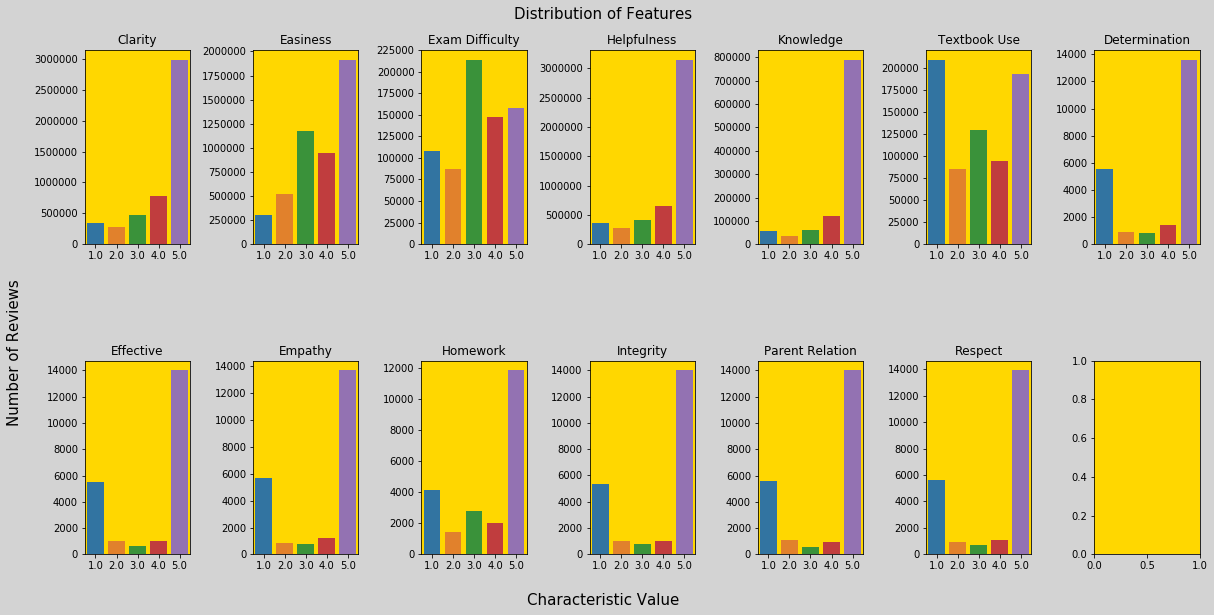

In [9]:
# lets graph the distribution of the characteristics we created
characteristics = ['Clarity','Easiness','Exam Difficulty','Helpfulness','Knowledge','Textbook Use','Determination','Effective','Empathy','Homework','Integrity','Parent Relation','Respect']

plt.rcParams['axes.facecolor']= 'gold'
plt.rcParams['figure.facecolor']= 'lightgray'

fig, axes = plt.subplots(2, 7)
plt.subplots_adjust(wspace=0.6, hspace=0.6, left=0.1, bottom=0.22, right=0.96, top=0.92)
axes = axes.flatten()
fig.set_size_inches(18, 10)
fig.suptitle('Distribution of Features', fontsize=15)

for i,n in enumerate(characteristics): 
    vc = data.loc[data[n].notnull()][n].value_counts()
    lbl = n
    sns.barplot(vc.keys(), vc.values, ax=axes[i]) 
    axes[i].title.set_text(n)
    
fig.text(0.5, 0.15, 'Characteristic Value', ha='center', fontsize=15)
fig.text(0.04, 0.5, 'Number of Reviews', va='center', rotation='vertical', fontsize=15)

Most of the charactersitics skew to the right. However, `Exam Difficulty` and `Textbook Use` have a majority of reviews below 5. Besides exam difficulty, most charactersitics have extreme distributions where the majority of reviews are either 5's or 1's.

*How many years worth of reviews to teachers have?*

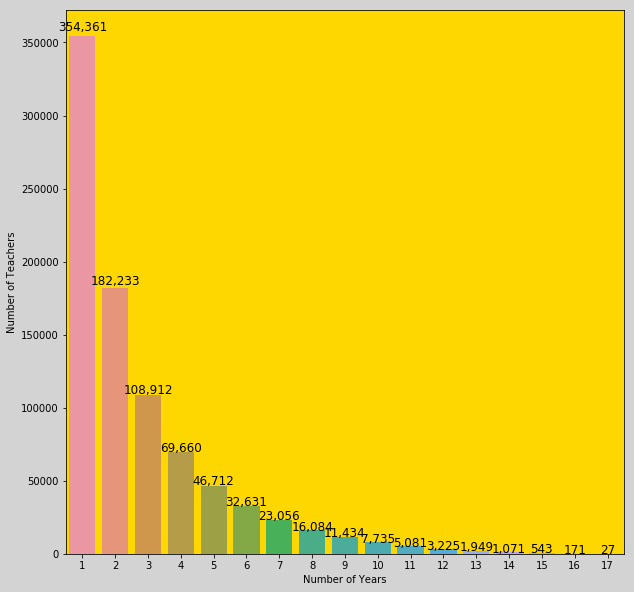

In [10]:
import matplotlib.pyplot as plt

fig = plt.figure(1, figsize = (10,10))
ax = fig.add_subplot(111)
ax.tick_params(axis='both', which='major', labelsize=10)
plt.rcParams['axes.facecolor']= 'gold'
plt.rcParams['figure.facecolor']= 'lightgray'
plt.rcParams.update({'font.size': 10})
plt.ylabel('Number of Teachers')
plt.xlabel('Number of Years')
number_of_years = n_years['Academic_Year'].apply(lambda y : len(y)).value_counts()
g = sns.barplot(number_of_years.keys(), number_of_years.values, ax = ax)
for i,v in enumerate(number_of_years.keys()): 
    g.text(i,number_of_years[v]*1.01, "{:,}".format(number_of_years[v]), fontsize = 12, color='black', ha="center")

Even though the majority of teachers don't have more than one review, there are plenty of them who have several years worth of data.

*Changes in ratings over time & difference between Max & Min Rating:*

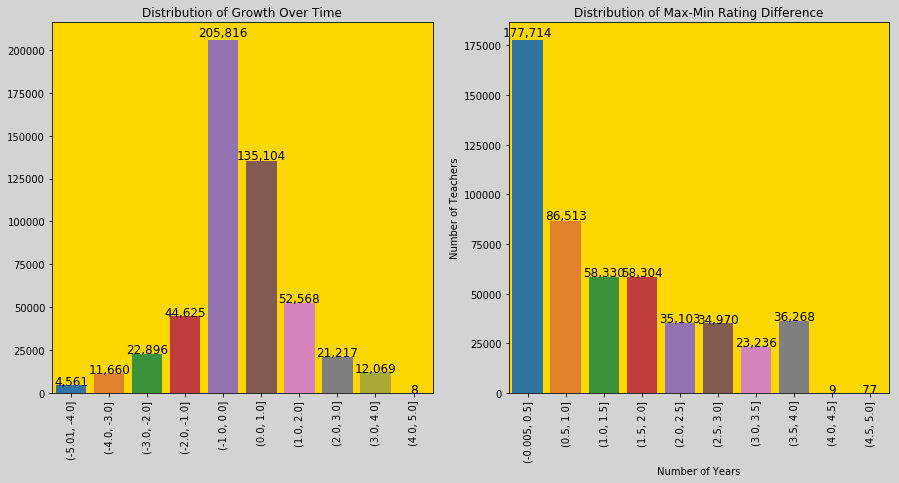

In [13]:
# rescale ratings to match the scores from the other characteristics
rating_by_year['Rating Scaled'] = rating_by_year['Rating']/rating_by_year['Rating'].max()*5
scores = ['Rating Scaled','Clarity','Easiness','Exam Difficulty','Helpfulness','Knowledge','Textbook Use','Determination','Effective','Empathy','Homework','Integrity','Parent Relation','Respect']
aggfunc = {} 
for s in scores: 
    aggfunc[s]=['first','last','min','max']
aggfunc['Ratings in Year']=['sum','count']
teacher_change = rating_by_year.groupby('Teacher').agg(aggfunc)

idx = pd.IndexSlice
change_over_time = pd.concat([teacher_change.loc[idx[:],idx[:,['first','last']]].diff(axis=1).loc[idx[:],idx[:,'last']].stack().reset_index().drop('level_1',1),
                              teacher_change['Ratings in Year','count'].reset_index(),
                              teacher_change['Ratings in Year','sum'].reset_index()],
                              axis = 1)

change_over_time = change_over_time[change_over_time[('Ratings in Year','count')]>1]
change_over_time['RatingBins'] = pd.cut(change_over_time['Rating Scaled'],10)

max_change = teacher_change.loc[idx[:],idx[:,['min','max']]].diff(axis=1).loc[idx[:],idx[:,'max']].stack().reset_index().drop('level_1',1)
max_change = pd.concat([teacher_change.loc[idx[:],idx[:,['min','max']]].diff(axis=1).loc[idx[:],idx[:,'max']].stack().reset_index().drop('level_1',1),
                              teacher_change['Ratings in Year','count'].reset_index()],
                              axis = 1)

max_change = max_change[max_change[('Ratings in Year','count')]>1]
max_change['RatingBins'] = pd.cut(max_change['Rating Scaled'],10)
max_change = max_change.rename(columns={'Rating Scaled':'Max Rating Change'})

import matplotlib.pyplot as plt

plt.rcParams['axes.facecolor']= 'gold'
plt.rcParams['figure.facecolor']= 'lightgray'

fig = plt.figure(1, figsize = (15,15))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax1.tick_params(axis='both', which='major', labelsize=10)
plt.rcParams['axes.facecolor']= 'gold'
plt.rcParams['figure.facecolor']= 'lightgray'
plt.rcParams.update({'font.size': 10})
plt.ylabel('Number of Teachers')
plt.xlabel('Number of Years')
plt.sca(ax1)
plt.xticks(rotation=90)
plt.sca(ax2)
plt.xticks(rotation=90)
ax1.set_title('Distribution of Growth Over Time')
ax2.set_title('Distribution of Max-Min Rating Difference')
cot = change_over_time['RatingBins'].value_counts().sort_index()
g = sns.barplot(cot.keys(), cot.values, ax = ax1)
for i,v in enumerate(cot.keys()): 
    g.text(i,cot[v]*1.01, "{:,}".format(cot[v]), fontsize = 12, color='black', ha="center")
    
mot = max_change['RatingBins'].value_counts().sort_index()
g = sns.barplot(mot.keys(), mot.values, ax = ax2)
for i,v in enumerate(mot.keys()): 
    g.text(i,mot[v]*1.01, "{:,}".format(mot[v]), fontsize = 12, color='black', ha="center")

*Difference between the early and later averages:*

In [14]:
# get a dataset with the average score of the first half and second half of annual reviews teachers received
def top_and_bottom(num):
    def top_ave(x):
        return np.mean(x.iloc[:len(x)//num])

    top_ave.__name__ = 'TopAve_'+str(num)

    def bottom_ave(x):
        return np.mean(x.iloc[len(x)//num:])

    bottom_ave.__name__ = 'BotAve_'+str(num)

    return top_ave, bottom_ave
    
# get the top half, third and quarter years worth of ratings for each teacher 
aggfunc = {'Rating Scaled': [top_and_bottom(2)[0], top_and_bottom(2)[1],
                             top_and_bottom(3)[0], top_and_bottom(3)[1],
                             top_and_bottom(4)[0], top_and_bottom(4)[1]]} 

avs = rating_by_year.groupby('Teacher').agg(aggfunc)

In [15]:
change_over_time = change_over_time.rename(columns={('Ratings in Year','count'):'Years of Ratings',
                                                    ('Ratings in Year','sum'):'Total Ratings',
                                                    'Rating Scaled':'Change in Rating'})
db = pd.merge(rating_by_year, change_over_time[['Teacher','Years of Ratings','Change in Rating','Total Ratings']], on='Teacher',how='inner', indicator = True)
df = db.pivot(index='Teacher',
         columns='Academic_Year',
         values='Rating Scaled')
df['Years of Data'] = df.count(axis=1)
df= pd.merge(df.reset_index(),change_over_time[['Teacher','Total Ratings','Change in Rating']], on='Teacher', how='inner')
df= pd.merge(df, max_change[['Teacher','Max Rating Change']], on='Teacher', how='inner')
df= pd.merge(df, avs.reset_index(), on='Teacher', how='inner')
for i in range(2,5):
    df['TB_Diff_'+str(i)] = df['Rating Scaled','TopAve_'+str(i)]- df[('Rating Scaled','BotAve_'+str(i))]
df= df.sort_values(by=['Years of Data','Total Ratings'], ascending=[False,False])

C:\Users\carlo\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:544: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
C:\Users\carlo\Anaconda3\lib\site-packages\pandas\core\generic.py:3111: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [16]:
print('Number of teachers with more than 20 ratings: ', len(df[df['Total Ratings']>20]))
print('Number of teachers with more than 4 years of data: ', len(df[df['Years of Data']>4]))
print('Number of teachers with more than 2 points difference between first and last year: ', len(df[abs(df['Change in Rating'])>2]))
print('Number of teachers with more than 2 points difference between max and min year: ', len(df[abs(df['Max Rating Change'])>2]))
print()
print('Number of teachers with more than 20 ratings, 4 years of data and 2 points difference between max and min year: ',
      len(df[(df['Total Ratings']>20)&(df['Years of Data']>4)&(abs(df['Max Rating Change'])>3)]))
print('Number of teachers with more than 20 ratings, 4 years of data and 2 points difference between first and last year: ',
      len(df[(df['Total Ratings']>20)&(df['Years of Data']>4)&(abs(df['Change in Rating'])>2)]))
print('Number of teachers that meet all of the above conditions: ',
      len(df[(df['Total Ratings']>20)&(df['Years of Data']>4)&(abs(df['Change in Rating'])>2)&(abs(df['Max Rating Change'])>3)]))

Number of teachers with more than 20 ratings:  41363
Number of teachers with more than 4 years of data:  149719
Number of teachers with more than 2 points difference between first and last year:  64356
Number of teachers with more than 2 points difference between max and min year:  129663

Number of teachers with more than 20 ratings, 4 years of data and 2 points difference between max and min year:  6944
Number of teachers with more than 20 ratings, 4 years of data and 2 points difference between first and last year:  3528
Number of teachers that meet all of the above conditions:  2212


Text(0,0.5,'Last Forth Yrs Ave - First Forth Yrs Ave')

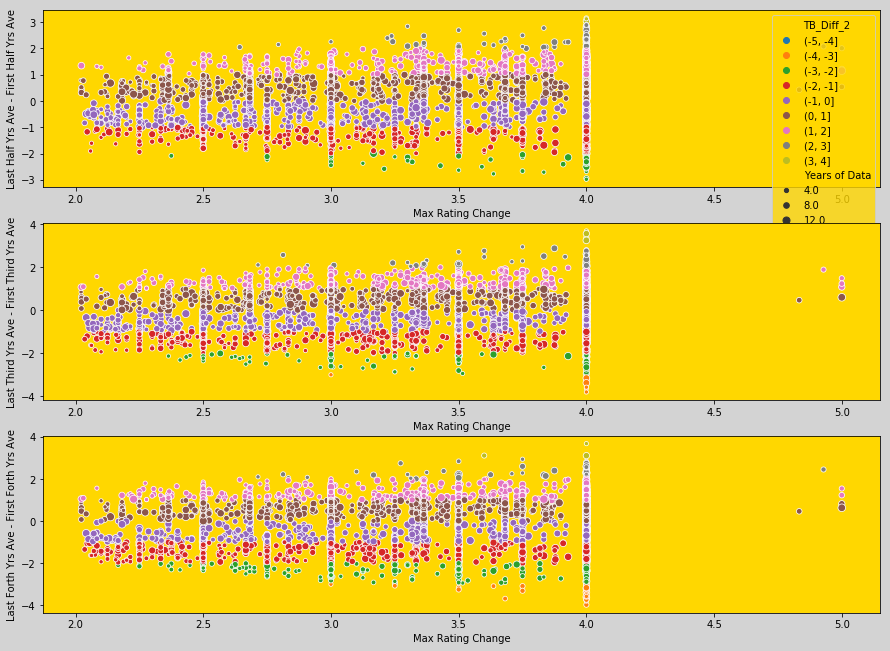

In [21]:
fig = plt.figure(1, figsize=(15,15))

marker_map = {} 
markers = [',','.','x','v','>','<','3','4','s','p']
for i,x in enumerate(list(pd.cut(df['TB_Diff_2'],list(range(-5,5,1))).value_counts().keys())):
    marker_map[x] = markers[i]
    
ax1 = fig.add_subplot(411)
ax2 = fig.add_subplot(412)
ax3 = fig.add_subplot(413)
#ax4 = fig.add_subplot(414)

g1=sns.scatterplot(x='Max Rating Change',
                y='TB_Diff_2', 
                data=df[(df['Years of Data']>4)&(abs(df['Change in Rating'])>2)&(df['Total Ratings']>20)], 
                hue=pd.cut(df['TB_Diff_2'],list(range(-5,5,1))), 
                markers=marker_map,
                size='Years of Data', 
                ax=ax1)
g2=sns.scatterplot(x='Max Rating Change',
                y='TB_Diff_3', 
                data=df[(df['Years of Data']>4)&(abs(df['Change in Rating'])>2)&(df['Total Ratings']>20)], 
                hue=pd.cut(df['TB_Diff_3'],list(range(-5,5,1))),
                markers=marker_map,
                size='Years of Data', 
                ax=ax2, legend=False)
g3=sns.scatterplot(x='Max Rating Change',
                y='TB_Diff_4', 
                data=df[(df['Years of Data']>4)&(abs(df['Change in Rating'])>2)&(df['Total Ratings']>20)], 
                hue=pd.cut(df['TB_Diff_4'],list(range(-5,5,1))), 
                markers=marker_map,
                size='Years of Data', 
                ax=ax3, legend=False)

ax1.set_ylabel('Last Half Yrs Ave - First Half Yrs Ave')
ax2.set_ylabel('Last Third Yrs Ave - First Third Yrs Ave')
ax3.set_ylabel('Last Forth Yrs Ave - First Forth Yrs Ave')

In [11]:
# find the reviews for teachers that have a large change between their maximum and minimum reviews
max_change_indices = pd.merge(df[(df['Total Ratings']>20)&(df['Years of Data']>4)&(abs(df['Max Rating Change'])>2)][['Teacher','Total Ratings','Years of Data','Max Rating Change']],
                              data[['Teacher','Rating','DateTime','Year','Month','Academic_Year']],
                              on='Teacher',
                              how='inner')
bn.compressed_pickle(os.getcwd()+'/data/cleaned_data/max_change_indices',max_change_indices) 

# find the reviews for teachers that have a large change between their first and last reviews
time_change_indices = pd.merge(df[(df['Total Ratings']>20)&(df['Years of Data']>4)&(abs(df['Change in Rating'])>2)][['Teacher','Total Ratings','Years of Data','Change in Rating']],
                              data[['Teacher','Rating','DateTime','Year','Month','Academic_Year']],
                              on='Teacher',
                              how='inner')
bn.compressed_pickle(os.getcwd()+'/data/cleaned_data/time_change_indices',time_change_indices) 

# find the reviews for teachers that have a large change between their first and last, and max and min reviews
large_change_indices = pd.merge(df[(df['Total Ratings']>20)&(df['Years of Data']>4)&(abs(df['Change in Rating'])>2)&(abs(df['Max Rating Change'])>3)][['Teacher','Total Ratings','Years of Data','Change in Rating']],
                              data[['Teacher','Rating','DateTime','Year','Month','Academic_Year']],
                              on='Teacher',
                              how='inner')

bn.compressed_pickle(os.getcwd()+'/data/cleaned_data/large_change_indices',large_change_indices) 